In [1]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
#import scipy.optimize as opt
from scipy import optimize
from scipy import signal
import os.path
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def radec_to_xyz(ra, dec):
    x = math.cos(np.deg2rad(dec)) * math.cos(np.deg2rad(ra))
    y = math.cos(np.deg2rad(dec)) * math.sin(np.deg2rad(ra))
    z = math.sin(np.deg2rad(dec))

    return np.array([x, y, z], dtype=np.float64)

#functions from sncosmo
def cmb_dz(ra, dec):
    """See http://arxiv.org/pdf/astro-ph/9609034
     CMBcoordsRA = 167.98750000 # J2000 Lineweaver
     CMBcoordsDEC = -7.22000000
    """

    # J2000 coords from NED
    CMB_DZ = 371000. / 299792458.
    CMB_RA = 168.01190437
    CMB_DEC = -6.98296811
    CMB_XYZ = radec_to_xyz(CMB_RA, CMB_DEC)

    coords_xyz = radec_to_xyz(ra, dec)
    
    dz = CMB_DZ * np.dot(CMB_XYZ, coords_xyz)

    return dz

def cmb_to_helio(z, ra, dec):
    """Convert from CMB-frame redshift to heliocentric redshift.
    
    Parameters
    ----------
    z : float
        CMB-frame redshift.
    ra, dec: float
        RA and Declination in degrees (J2000).
    """

    dz = -cmb_dz(ra, dec)
    one_plus_z_pec = math.sqrt((1. + dz) / (1. - dz))
    one_plus_z_helio = (1. + z) * one_plus_z_pec

    return one_plus_z_helio - 1.


In [2]:
def one_lenght_redshift(u):
    
    redshift_value = None
    
    #if there is kind in the list continue
    if "kind" in data[url]["redshift"][0]:

        #if its heliocentric pick then
        if data[url]["redshift"][0]["kind"] == "heliocentric":

            redshift_value = float(data[url]["redshift"][0]["value"])
            print(redshift_value)
        
        #if its cmb pick then    
        if data[url]["redshift"][0]["kind"] == "cmb":

            #convertion of hours to degrees
            if data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "degrees":

                c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.deg))

            elif data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "hours":

                c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.hourangle))

            else:

                print("Erro!")

            redshift_value = float(cmb_to_helio(float(data[url]["redshift"][0]["value"]), c.ra.deg, c.dec.deg))
            print(redshift_value)
      
    #if there is only 1 and its not specificated
    else:
            
        redshift_value = float(data[url]["redshift"][0]["value"])
        print(redshift_value)
    
    return redshift_value

In [3]:
def redshift_selection(url):
    
    redshift_value = None
    
    for nredshift in range(0,len(data[url]["redshift"])):
            
        #if there is kind in the list continue
        if "kind" in data[url]["redshift"][nredshift]:

            #if its heliocentric pick then
            if data[url]["redshift"][nredshift]["kind"] == "heliocentric":

                redshift_value = float(data[url]["redshift"][nredshift]["value"])
                print(redshift_value)
                break
                
            
            #if its cmb 
            if data[url]["redshift"][nredshift]["kind"] == "cmb":

                #convertion of hours to degrees
                if data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "degrees":

                    c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.deg))

                elif data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "hours":

                    c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.hourangle))

                else:

                    print("Erro 1!")

                #convertion of cmb to heliocentric
                redshift_value = float(cmb_to_helio(float(data[url]["redshift"][nredshift]["value"]), c.ra.deg, c.dec.deg))
                print(redshift_value)
                break
            
    return redshift_value

In [4]:
def redshift_HB(url):
    redshift_value = None
    
    maxredshift = None
    
    sumredshift = 0
    HB_test = 0
    for nredshift in range(0,len(data[url]["redshift"])):
            
        #if not realize a sum to obtain a mean value
        if "kind" not in data[url]["redshift"][nredshift]:
            
            sumredshift = sumredshift + float(data[url]["redshift"][nredshift]["value"])
                
            #if the sn is in the hubnle flow realize a mean value of the redshifts
            if float(data[url]["redshift"][nredshift]["value"]) > 0.15:
                
                HB_test = 1
                
            #if not the first redshift is the max redshift
            if nredshift == 0:
                maxredshift = float(data[url]["redshift"][nredshift]["value"])
                
            if nredshift > 0 and maxredshift is not None:
                #then analise if the next redshift is grater than max redshift 
                if float(data[url]["redshift"][nredshift]["value"]) > maxredshift:
                        
                    maxredshift = float(data[url]["redshift"][nredshift]["value"])
        
    if HB_test == 1:
            
        #if sne is in the hubble flow realize a mean value
        redshift_value = sumredshift/len(data[url]["redshift"])
        print(redshift_value)  
    elif HB_test == 0:
            
        #if not the maximum redshift is the heliocentric redshift
        redshift_value = maxredshift
        print(redshift_value)
        
    return redshift_value

In [5]:
def redshift_value(url):
    redshift_func = None
    #if there is 1 value use it
    if len(data[url]["redshift"]) == 1:
        
        redshift_func = one_lenght_redshift(url)

    #if not...
    if len(data[url]["redshift"]) == 1 and redshift_func is None:
        
        print("redshift nao encontrado")
        
    if len(data[url]["redshift"]) > 1:
        
        redshift_func = redshift_selection(url)
                
    if len(data[url]["redshift"]) > 1 and redshift_func is None:
        redshift_func = redshift_HB(url)
        
    return redshift_func

In [6]:
def max_time(url):
    
    t0_max_photo = None
    alert_photo = 0
    
    dat_photo_vega = []
    dat_photo_csp = []
    dat_photo_ab = []
    dat_photo_Swope = []
    #dat_photo_Sem = []
    dat_photo_Swift = []
    
    
 
    for k in range(0,len(data[url]["photometry"])):
        
        
        if "band" in data[url]["photometry"][k]:
            
            if data[url]["photometry"][k]["band"] == "B":
                
                
                
                if "system" in data[url]["photometry"][k]:
                    
                    if data[url]["photometry"][k]["system"] == "Vega":
                
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_vega.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])

    
                    if data[url]["photometry"][k]["system"] == "CSP":
            
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_csp.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
            
            

                    if data[url]["photometry"][k]["system"] == "AB":
            
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_ab.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
 
            
    
                    if data[url]["photometry"][k]["system"] == "Swope":
            
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_Swope.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
      
                
                    if data[url]["photometry"][k]["system"] == "Swift":
            
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_Swift.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
      
                      
                '''
                if "system" not in data[url]["photometry"][k]:
        
                    if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_Sem.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
    
                '''
                       
    #print("---------------------------------------------------------")
    df_photo_vega = pd.DataFrame(dat_photo_vega, columns=['x','y'])

    df_photo_vega.sort_values(by=['x'])
    
    
    df_photo_csp = pd.DataFrame(dat_photo_csp, columns=['x','y'])

    df_photo_csp.sort_values(by=['x'])  
    
    
    df_photo_ab = pd.DataFrame(dat_photo_ab, columns=['x','y'])

    df_photo_ab.sort_values(by=['x']) 
    
    df_photo_Swope = pd.DataFrame(dat_photo_Swope, columns=['x','y'])

    df_photo_Swope.sort_values(by=['x']) 
    
    '''
    df_photo_Sem = pd.DataFrame(dat_photo_Sem, columns=['x','y'])

    df_photo_Sem.sort_values(by=['x']) 
    '''
    
    df_photo_Swift = pd.DataFrame(dat_photo_Swift, columns=['x','y'])

    df_photo_Swift.sort_values(by=['x']) 
    #print(df_photo['x'])
    

    
    if len(df_photo_vega['y']) > 0:
    
    
        min_pos_photo = df_photo_vega['y'].idxmin(axis=0)

        if min_pos_photo > 3:
            f = interp1d(df_photo_vega['x'], df_photo_vega['y'], kind="linear", fill_value="extrapolate")

            result = optimize.minimize_scalar(f)

            if result.success == True:
                alert_photo = 1
                #print("sucesso no vega")
                if df_photo_vega['x'][0] < result.x < df_photo_vega['x'][len(df_photo_vega['x'])-1]:
                    
                    t0_max_photo = result.x
                    
                    
    if len(df_photo_csp['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_csp['y']) > 0:
    
                
            min_pos_photo = df_photo_csp['y'].idxmin(axis=0)

            if min_pos_photo > 3:
                
                f = interp1d(df_photo_csp['x'], df_photo_csp['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no csp")
                    if df_photo_csp['x'][0] < result.x < df_photo_csp['x'][len(df_photo_csp['x'])-1]:

                        t0_max_photo = result.x
                        
    if len(df_photo_ab['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_ab['y']) > 0:
                            
            min_pos_photo = df_photo_ab['y'].idxmin(axis=0)
            #print(min_pos_photo)
            if min_pos_photo > 3:
                
                f = interp1d(df_photo_ab['x'], df_photo_ab['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no ab")
                    if df_photo_ab['x'][0] < result.x < df_photo_ab['x'][len(df_photo_ab['x'])-1]:

                        t0_max_photo = result.x
                        
    if len(df_photo_Swope['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_Swope['y']) > 0:
                
            min_pos_photo = df_photo_Swope['y'].idxmin(axis=0)
            #print(min_pos_photo)
            if min_pos_photo > 3:
                
                f = interp1d(df_photo_Swope['x'], df_photo_Swope['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no ab")
                    if df_photo_Swope['x'][0] < result.x < df_photo_Swope['x'][len(df_photo_Swope['x'])-1]:

                        t0_max_photo = result.x
    '''                 
    if len(df_photo_Sem['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_Sem['y']) > 0:
            
            datax_Sem.append(np.array(df_photo_Sem['x']))
            datay_Sem.append(np.array(df_photo_Sem['y']))
                
            min_pos_photo = df_photo_Sem['y'].idxmin(axis=0)
            #print(min_pos_photo)
            if min_pos_photo > 3:
                
                f = interp1d(df_photo_Sem['x'], df_photo_Sem['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no ab")
                    if df_photo_Sem['x'][0] < result.x < df_photo_Sem['x'][len(df_photo_Sem['x'])-1]:

                        t0_max_photo = result.x
                        
    '''
    
    if len(df_photo_Swift['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_Swift['y']) > 0:
                            
            min_pos_photo = df_photo_Swift['y'].idxmin(axis=0)
            #print(min_pos_photo)
            if min_pos_photo > 3:
                
                f = interp1d(df_photo_Swift['x'], df_photo_Swift['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no ab")
                    if df_photo_Swift['x'][0] < result.x < df_photo_Swift['x'][len(df_photo_Swift['x'])-1]:

                        t0_max_photo = result.x
    
    #t0_max_photo = None
    
    
    if t0_max_photo is not None:
        
        return t0_max_photo
    
    else:
        
        
        t0dat = data[url]["maxdate"][0]["value"]
        t0_max_photo = t0dat.split("/")
        t0_max_photo=str(t0_max_photo[0])+'-'+str(t0_max_photo[1])+'-'+str(t0_max_photo[2])
        t0_max_photo=Time(t0_max_photo).mjd
        
        return t0_max_photo
    

In [7]:
def suavization(x):
    
    b, a = signal.butter(8, 0.14)
    y = signal.filtfilt(b, a, x, padlen=0)
    
    return y

In [8]:
def gaussian(wavet, fluxt):
    
    final_flux = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 
    
    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
    
    final_list_data = [[] for x in range(0,len(final_gradey))]
    
    
    for l in range(0,len(wavet)):
        
        if len(wavet[l]) > 0:   
            
            interpolation = interp1d(wavet[l][0], fluxt[l][0])

            for j in range(0,len(final_gradey)):

                if min(wavet[l][0]) < final_gradey[j] < max(wavet[l][0]):

                    if interpolation(final_gradey[j]) > 0.01:
                        final_list_data[j].append([final_gradex[l],interpolation(final_gradey[j])])
    
    
    
    for l in range(0,len(final_list_data)):
        
        x = []
        y = []
        
        if len(final_list_data[l]) > 20:
            
            for j in range(0,len(final_list_data[l])):
                
                x.append([final_list_data[l][j][0]])
                y.append(final_list_data[l][j][1])
                
                
        if len(x) > 0:
            
            xidx = []
            for hh in range(0,len(x)):
                
                xidx.append(x[hh][0])
                
            X_ = np.linspace( min(xidx), max(xidx), max(xidx)-min(xidx) + 1)
            
            #print(X_)
            
            gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(x, y)
            
            y_mean= gp.predict(X_[:, np.newaxis])
        
            for h in range(0,len(X_)):
                
                xpos =  [ii for ii,xx in enumerate(final_gradex) if xx == X_[h]]
                
                final_flux[l][xpos[0]].append(y_mean[h])
            
            
    return final_flux

In [9]:
#sn_names=glob.glob("*.json")
#sn_names=["SN2012fr.json"]

file = open("newtraining.txt")
lines = file.readlines()
file.close()

sn_names = []

for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()
    sn_names.append(co[0])


In [10]:
len(sn_names)

16

In [11]:
#save_path = '/home/user/Área de Trabalho/salt2templates/data'

In [12]:
saltname="salt2_template_0.dat"

In [13]:
file = open(saltname)
lines = file.readlines()
file.close()

In [14]:
x_salt = []
y_salt = []
z_salt = []

#to separate the collumns
for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()
        
    #saving in temporary lists
    x_salt.append(co[0])
    y_salt.append(co[1])
    z_salt.append(co[2])

#to float
x_salt = np.array(x_salt, dtype=float)
y_salt = np.array(y_salt, dtype=float)
z_salt = np.array(z_salt, dtype=float)

In [15]:
maxv = []
for i in range(0, 71):
    
    maxv.append(z_salt[721*i + 200])

In [16]:
final_gradex = np.linspace(-20, 50, 71)
final_gradey = np.linspace(2000, 9200, 721)

list_data = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 
number_data_density = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 

for u in range(0,len(sn_names)):
    
    wave = [[] for x in range(0,len(final_gradex))]
    flux = [[] for x in range(0,len(final_gradex))]
    
    print(sn_names[u])

    #reading the .json file
    with open(sn_names[u], "r") as read_file:
        data = json.load(read_file)

    #catching the name of supernova
    url=sn_names[u]
    if url.endswith('.json'):
        url = url[:-5]
    #print(url)
    #defining the lists

    redshift = redshift_value(url)
        
    #print("valor final")    
    #print(redshift)
    
    
    spec_functions = []
    max_min = []
    
    t0 = max_time(url)
    if redshift is not None and t0 is not None:
        
        #spectra data
        i=0
        n=0
        while i < len(data[url]["spectra"]):


            if "time" in data[url]["spectra"][i]:

                spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
                #print(spectratime)

            alert3 = 0
            #if its the first spectra then previous time is the first time
            if i == 0:
                previoustime = spectratime

            else:
                #if the diference between the time and previous time is more than * days so emmit an alert to continue
                if (spectratime - previoustime) < 2000:

                    alert3 = 1
                    previoustime = spectratime

            #if the diference of time is less than * continue
            if alert3 == 1:

                #verifing if its calibrated and if it have a redshift correction 
                alert1 = 0 #for calibration
                alert2 = 0 #for redshift correction

                if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                    alert1 = 1 #first alert

                    if "deredshifted" in data[url]["spectra"][i]:
                        alert2 = 1 #second alert

                #if its calibrated and corrected
                if alert1 == 1 and alert2 == 1:

                    #there are 3 collumns: wavelength flux and flux error 
                    if len(data[url]["spectra"][i]["data"][0]) == 3:

                        n = n + 1

                    #there are 2 collumns: wavelength and flux
                    elif len(data[url]["spectra"][i]["data"][0]) == 2:

                        n = n + 1

                #if its calibrated, redshift not adjusted but with a clear redshift
                elif alert1 ==1 and alert2 == 0:   

                    #there are 3 collumns: wavelength flux and flux error 
                    if len(data[url]["spectra"][i]["data"][0]) == 3:

                        n = n + 1

                    #there are 2 collumns: wavelength and flux
                    elif len(data[url]["spectra"][i]["data"][0]) == 2:

                        n = n + 1

            i = i + 1

       
        
        if n > 9:
        

            #print(redshift)
            spectra_data = 0
            i=0
            n=0
            times = []
            max_fluxes = []
            time_verification = 0
            wavelength_verification = 0
            while i < len(data[url]["spectra"]):

                if "time" in data[url]["spectra"][i]:

                    spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
                    #print(spectratime)
                    #verifing if its calibrated and if it have a redshift correction 
                    alert1 = 0 #for calibration
                    alert2 = 0 #for redshift correction

                    if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                        alert1 = 1 #first alert

                        if "deredshifted" in data[url]["spectra"][i]:
                            alert2 = 1 #second alert

                    #if its calibrated and corrected
                    if alert1 == 1 and alert2 == 1:
                        #print("ok")
                        #there are 3 collumns: wavelength flux and flux error
                        if len(data[url]["spectra"][i]["data"][0]) == 3:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)            
                 
                            #making a list of lists 
                            
                            suavf = suavization(fluxtemp)
                                               
                            for x in range(0,len(final_gradex)):
                                
                                if len(wave[x]) ==0:

                                    if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                        wave[x].append(df['wavelength'])
                                        flux[x].append(suavf)  

                                
                        
                        
                        #there are 2 collumns: wavelength and flux
                        if len(data[url]["spectra"][i]["data"][0]) == 2:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)            
              
                            #making a list of lists 
                            suavf = suavization(fluxtemp)

                            for x in range(0,len(final_gradex)):
                                
                                if len(wave[x]) ==0:

                                    if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                        wave[x].append(df['wavelength'])
                                        flux[x].append(suavf)  
                      
       

                            
                    #if its calibrated, redshift not adjusted but with a clear redshift
                    if alert1 ==1 and alert2 == 0:   

                        #there are 3 collumns: wavelength flux and flux error 
                        if len(data[url]["spectra"][i]["data"][0]) == 3:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)


                            #redshift correction
                            fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                            df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                            spectratime = spectratime/(1+redshift) #for time
                 
                            #making a list of lists 
                            suavf = suavization(fluxtemp)
                            
                            for x in range(0,len(final_gradex)):
                                
                                if len(wave[x]) ==0:

                                    if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                        wave[x].append(df['wavelength'])
                                        flux[x].append(suavf)  

                             
                            
                            
                            
                        #there are 2 collumns: wavelength flux and flux error 
                        if len(data[url]["spectra"][i]["data"][0]) == 2:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)

                            #redshift correction
                            fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                            df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                            spectratime = spectratime/(1+redshift) #for time
               
                            #making a list of lists 
                            suavf = suavization(fluxtemp)                       
                                                       
                            for x in range(0,len(final_gradex)):
                                
                                if len(wave[x]) ==0:

                                    if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                        wave[x].append(df['wavelength'])
                                        flux[x].append(suavf)  
   
                        
                i = i + 1

    new_flux = [[] for x in range(0,len(final_gradex))]
    new_wave = [[] for x in range(0,len(final_gradex))]
    
    for k in range(0,len(wave)):

        if len(wave[k])>0:

            if min(wave[k][0]) < 3500 and max(wave[k][0])> 4500:

                interpolation = interp1d(wave[k][0], flux[k][0])

                valor = maxv[k]/interpolation(4000)

                new_flux[k].append(flux[k][0]*valor)
                new_wave[k] = wave[k]
                
    flux = []
    wave = []
    
    gauss = gaussian(new_wave,new_flux)
    
    for i in range(0,len(final_gradey)):
        for j in range(0,len(final_gradex)):
            
            if len(gauss[i][j]) > 0:
                #print(gauss[i][j])
                list_data[i][j].append(gauss[i][j][0])
                number_data_density[i][j].append(1)
    gauss = []

SN2012fr.json


/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2346: RuntimeWarning: overflow encountered in double_scalars
  if (w - xc) * (xb - w) > 0.0:
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2362: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(wlim - xc) >= 0.0:
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2341: RuntimeWarning: overflow encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2334: RuntimeWarning: overflow encountered in double_scalars
  tmp1 = (xb - xa) * (fb - fc)
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2335: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = (xb - xc) * (fb - fa)
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2336: RuntimeWarning: invalid value encountered in double_scalars
  

0.0054
SN2011hr.json
0.013279
SN2002fk.json
0.007132
SN1997bp.json
0.008309
SN2005cf.json
0.006461
SN2009aa.json
0.02731
SN2006is.json
0.031330480283491946
SN2007if.json
0.07423915994326902
SN2007bm.json
0.006211
SN2004gs.json
0.02660272499077032
SN1999dq.json
0.01433
SN2002jy.json
0.0196
SN2008ar.json
0.026147
SN2006lf.json
0.013189
SN2002de.json
0.028116
SN2006hb.json
0.0153328042114802


In [26]:
mean_flux = []
desv_pad = []
xx_test = []
yy_test = []
fluxes_hist = []
number_fluxes = []

In [27]:
mean_value = []
std_value = []
number_fluxes = []
fluxes_hist = []
alerta = 0
density = []
density_x = []
density_y = []


for m in range(0,len(final_gradey)):
    for n in range(0,len(final_gradex)):
        
        #print(len(final_flux[m][n]))
        
        
        if len(list_data[m][n]) > 0:
           
            s = 0
            lenght = 0
            for i in range(0, len(list_data[m][n])):
                #print(final_flux[m][n][i])
                
                #if abs(final_flux[m][n][i]-mean_value) < std_value:
                #print("ok")
                
                s = s + list_data[m][n][i]
                lenght = lenght + 1
                    
                    
                    
            if lenght > 0:
                '''
                desvpad_sum = 0
                for j in range(0, len(list_data[m][n])):
                    
                    if abs(list_data[m][n][j]-mean_value) < std_value:
                        
                        desvpad_sum += (list_data[m][n][j] - s/lenght)**2
                '''
                #print("!")
                mean_flux.append(s/lenght)
                #desv_pad.append(desvpad_sum/lenght)
                xx_test.append(final_gradex[n])
                yy_test.append(final_gradey[m])

            
                #print(lenght)
                density.append(lenght)
                density_x.append(final_gradex[n])
                density_y.append(final_gradey[m])

            else:

                density.append(0)
                density_x.append(final_gradex[n])
                density_y.append(final_gradey[m])                
            
            '''
            dt_test = pd.DataFrame(list_data[m][n])
            
            #with pandas statistics
            mean_flux.append(dt_test.median()[0])
            xx_test.append(final_gradex[m])
            yy_test.append(final_gradey[n])
            '''

<IPython.core.display.Javascript object>


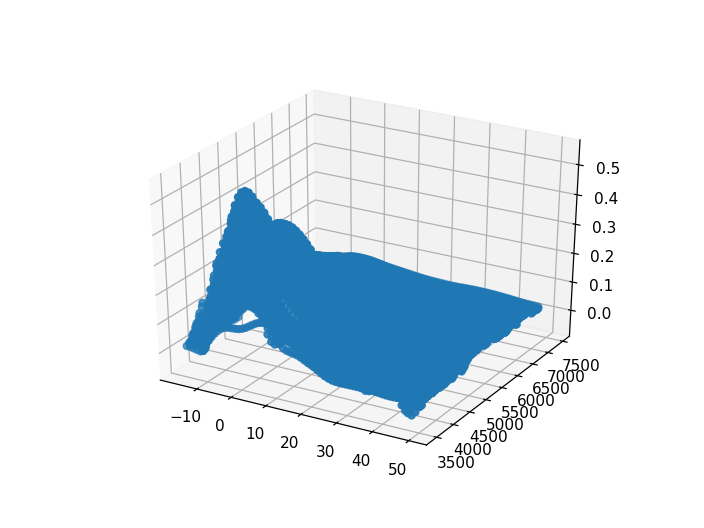

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx_test, yy_test, mean_flux)
#ax.set_zlim3d(0,0.1e-12)

plt.show()

In [29]:
x_grid = np.linspace(-20, 50, 71)
y_grid = np.linspace(3800, 9200, 500)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

<IPython.core.display.Javascript object>


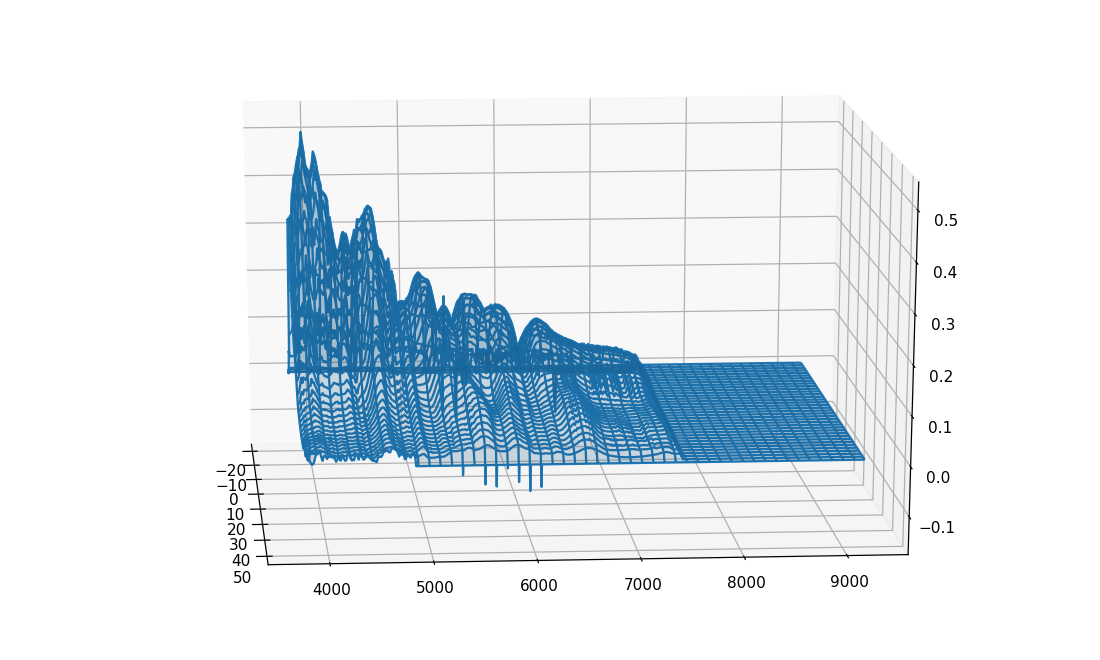

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
Z = interp.griddata((xx_test,yy_test),mean_flux,(B1,B2),method='cubic',fill_value = 0,rescale=True)
#Z = splinemean(B1, B2)
%matplotlib notebook
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
#ax.scatter3D(xx_test,yy_test,mean_flux, c='r')

plt.show()

In [31]:
density_x = []
density_y = []
density_z = []

for i in range(0,len(final_gradex)):
    for j in range(0,len(final_gradey)):
        
        density_x.append(final_gradex[i])
        density_y.append(final_gradey[j])
        density_z.append(sum(number_data_density[j][i]))
        
        

In [32]:
len(density_z)

51191

<IPython.core.display.Javascript object>


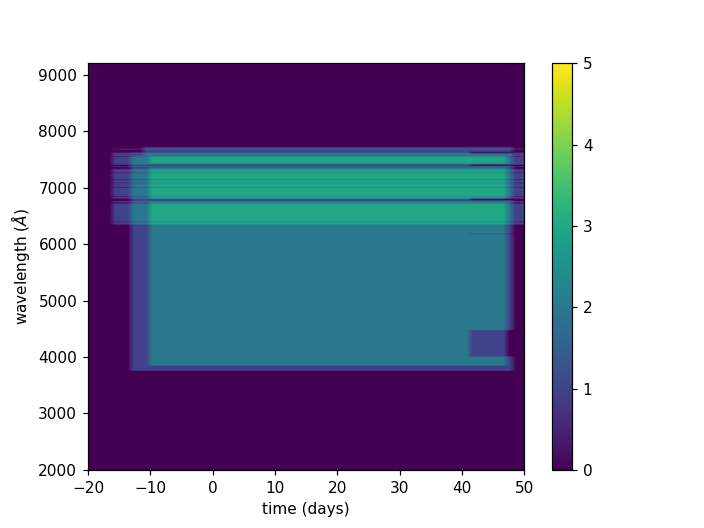

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook
z = np.reshape(density_z, (71, 721)).T
plt.imshow(z, extent=(np.amin(density_x), np.amax(density_x), np.amin(density_y), np.amax(density_y)), cmap=cm.viridis, aspect='auto', interpolation = 'bilinear')
plt.colorbar()
plt.clim(0,5)
plt.xlabel('time (days)')
plt.ylabel('wavelength ($\AA$)')
plt.savefig('densityplot.png')
plt.show()

In [36]:
import os.path 

save_path = '/home/user/Área de Trabalho/mathematica_analisys'

table = []
for k in range(0,len(mean_flux)):
    table.append((xx_test[k], yy_test[k], mean_flux[k]))


name_of_file = 'M0'

completeName = os.path.join(save_path, name_of_file+".dat")      
    
    
f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()
